# Dataset: Rock, Paper, Scissor

## 1. Import data and libraries

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


Import data from Tensorflow

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
data, info = tfds.load(
    'rock_paper_scissors',
    as_supervised=True,  
    with_info=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteLDLQLU/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteLDLQLU/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [ ]:
train_data, test_data = data['train'], data['test']

In [ ]:
print(len(list(train_data)))
print(len(list(test_data)))

2520
372


In [ ]:
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [ ]:
# Function to convert label ID to labels string.
get_label_name = info.features['label'].int2str

class_names = [get_label_name(0), get_label_name(1), get_label_name(2)]
class_names

['rock', 'paper', 'scissors']

Preview the dataset

In [ ]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

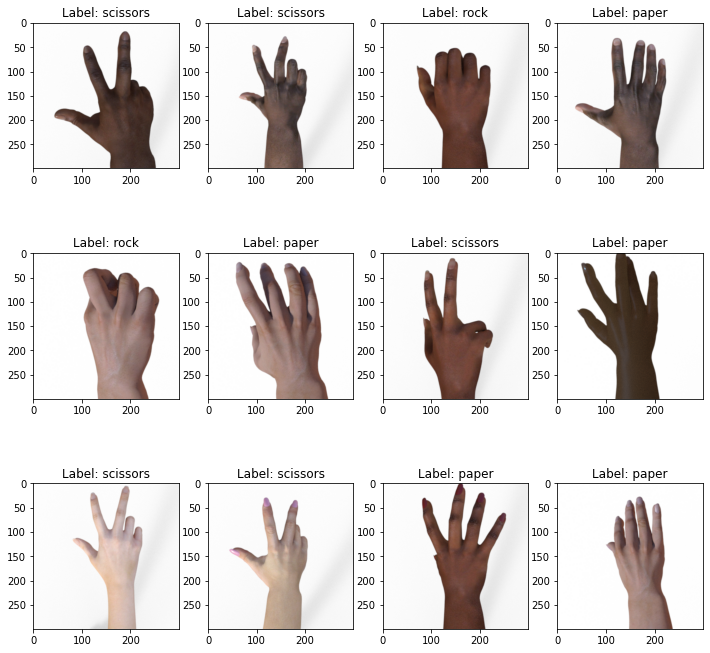

In [ ]:
preview_dataset(train_data)

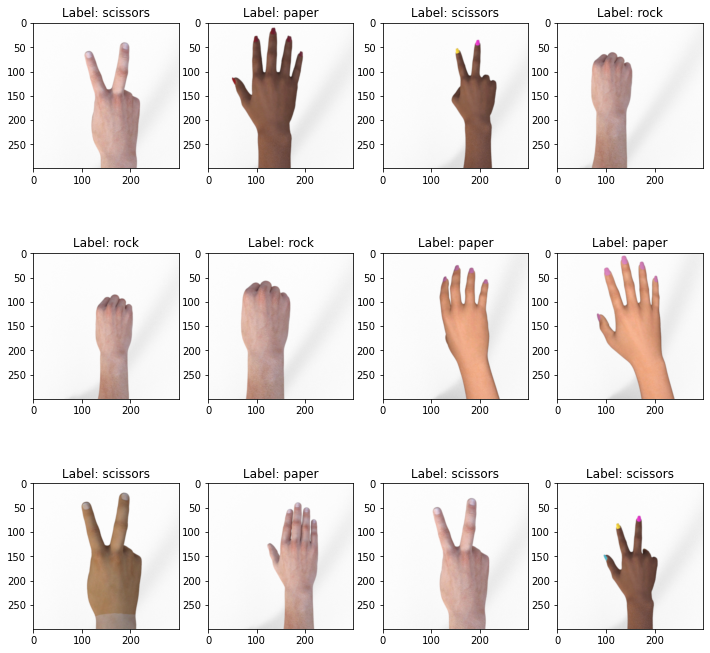

In [ ]:
preview_dataset(test_data)

## 2. Preprocess the data

In [ ]:
# 10 % of the train data as validation data
num_validation = 0.1 * info.splits['train'].num_examples

# Turning it to an integer as a float may cause problem along the way
num_validation = tf.cast(num_validation, tf.int64)

In [ ]:
# Since we are performing hold out validation we want to scale and shuffle at all times before taking out the validation set
def preprocess(image, labels):
  image = tf.cast(image, tf.float32)
  image /= 255.
  return image,labels
  
valid_train_data = train_data.map(preprocess)
test_images = test_data.map(preprocess)

In [ ]:
#Shuffle the data 
valid_train_data_shuffled = valid_train_data.shuffle(1000)

#Let's set out the validation data from the train data
valid_data = valid_train_data_shuffled.take(num_validation)
train_data = valid_train_data_shuffled.skip(num_validation)

#Set no of bath size for test
num_test = info.splits['test'].num_examples
num_test = tf.cast(num_test, tf.int64)

In [ ]:
# Batching and prefetching
batch_size = 32
train_data = train_data.batch(batch_size).prefetch(1)
valid_data = valid_data.batch(num_validation).prefetch(1)
test_images = test_images.batch(num_test).prefetch(1)

# Seperating labels and images
train_images, train_labels = next(iter(train_data))
valid_images, valid_labels = next(iter(valid_data))
test_images, test_labels = next(iter(test_images))

train_images = tf.image.resize(train_images, (150, 150))
valid_images = tf.image.resize(valid_images, (150, 150))
test_images = tf.image.resize(test_images, (150, 150))

# Checking the shape
train_images.shape

TensorShape([32, 150, 150, 3])

In [ ]:
test_images.shape

TensorShape([372, 150, 150, 3])

### Use ImageDataGenerator to prevent overfit

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,  horizontal_flip=True)

it_gen = datagen.flow(train_images, train_labels, batch_size=32)

## Create the model

In [ ]:
# Importing the necessary libraries
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import numpy as np

In [ ]:
model = Sequential([
                    Conv2D(32, (3, 3), 
                           activation='relu', 
                           input_shape=(150, 150, 3)), 
                    MaxPooling2D((2, 2)), 


                    Conv2D(32, (3, 3), activation='relu'), 
                    MaxPooling2D((2, 2)), 


                    Conv2D(64, (3, 3), activation='relu'), 
                    MaxPooling2D((2, 2)), 

                    Conv2D(64, (3, 3), activation='relu'), 
                    MaxPooling2D((2, 2)), 

                    Conv2D(128, (3, 3), activation='relu'), 
                    MaxPooling2D((2, 2)),


                    Flatten(), 
                    Dense(128, activation='relu'), 
                    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 64)       

In [ ]:
# Optimize the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'])

In [ ]:
steps = int(train_images.shape[0] / 32)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(it_gen, epochs = 200, validation_data = (valid_images, valid_labels), 
                    steps_per_epoch=steps, verbose=2)

Epoch 1/200
1/1 - 0s - loss: 0.2957 - acc: 0.9062 - val_loss: 0.2364 - val_acc: 0.9048
Epoch 2/200
1/1 - 0s - loss: 0.3584 - acc: 0.8438 - val_loss: 0.2394 - val_acc: 0.9246
Epoch 3/200
1/1 - 0s - loss: 0.2589 - acc: 0.9375 - val_loss: 0.2734 - val_acc: 0.9127
Epoch 4/200
1/1 - 0s - loss: 0.2594 - acc: 0.9375 - val_loss: 0.3158 - val_acc: 0.9087
Epoch 5/200
1/1 - 0s - loss: 0.1854 - acc: 0.9688 - val_loss: 0.3545 - val_acc: 0.8810
Epoch 6/200
1/1 - 0s - loss: 0.1859 - acc: 0.9688 - val_loss: 0.3418 - val_acc: 0.8810
Epoch 7/200
1/1 - 0s - loss: 0.2371 - acc: 0.9375 - val_loss: 0.3098 - val_acc: 0.9048
Epoch 8/200
1/1 - 0s - loss: 0.2717 - acc: 0.9062 - val_loss: 0.2443 - val_acc: 0.9206
Epoch 9/200
1/1 - 0s - loss: 0.1186 - acc: 0.9688 - val_loss: 0.1920 - val_acc: 0.9206
Epoch 10/200
1/1 - 0s - loss: 0.1220 - acc: 0.9688 - val_loss: 0.1617 - val_acc: 0.9286
Epoch 11/200
1/1 - 0s - loss: 0.1512 - acc: 0.9688 - val_loss: 0.1497 - val_acc: 0.9365
Epoch 12/200
1/1 - 0s - loss: 0.1657 - ac

In [ ]:
# Print the accuracy
_, acc = model.evaluate(test_images, test_labels, verbose=0)
print('Accuracry: {}'.format(acc * 100.0))

Accuracry: 95.16128897666931


## Visualize the model

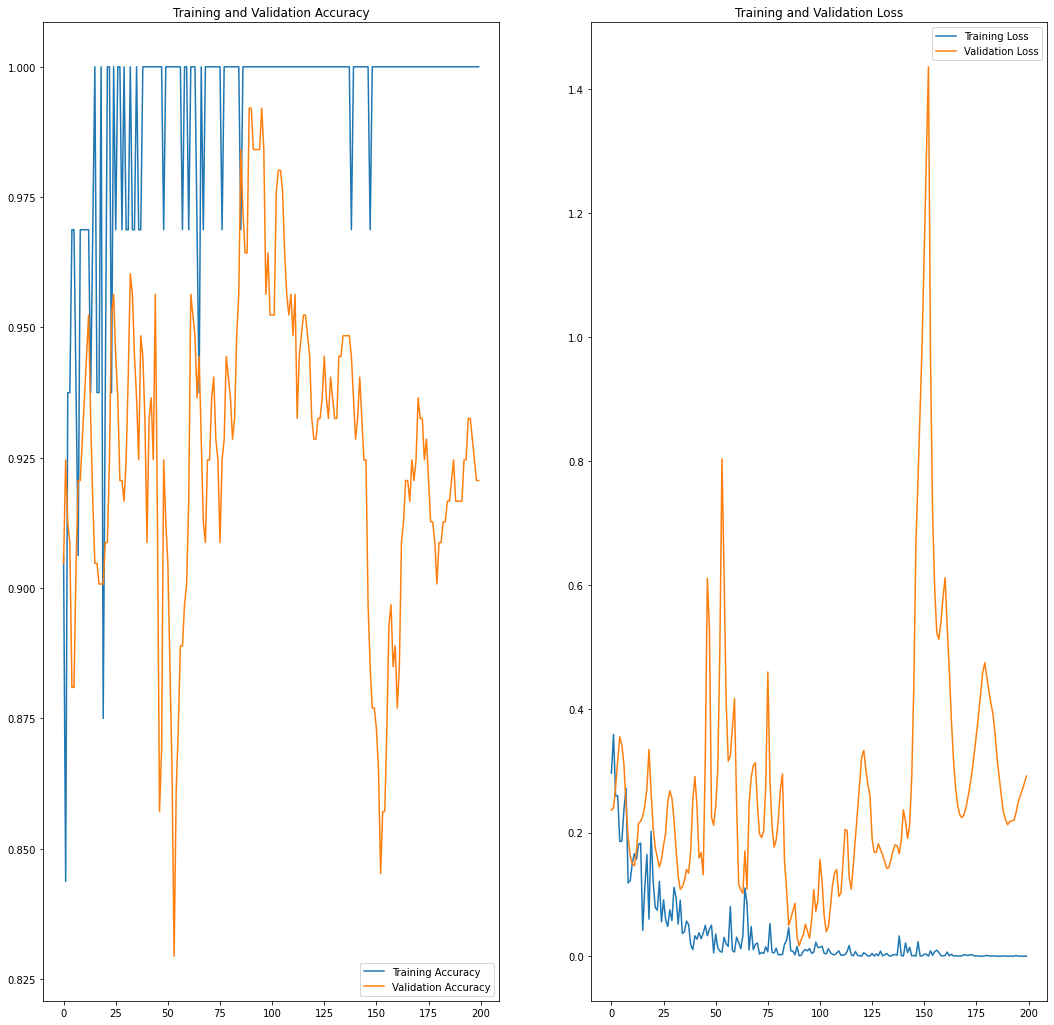

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = 200

plt.figure(figsize=(18, 18))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediction

Text(0.5, 0, 'rock')

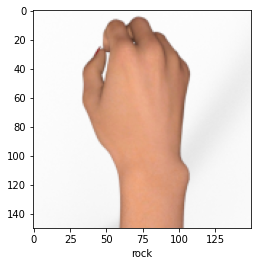

In [ ]:
TEST_NUM = 100
plt.imshow(test_images[TEST_NUM])
plt.xlabel(class_names[test_labels[TEST_NUM]])

In [ ]:
test_images[100].shape

TensorShape([150, 150, 3])

In [ ]:
tensor_shape = np.array(test_images[100])
test_shape = np.expand_dims(tensor_shape, axis=0)
test_shape.shape

(1, 150, 150, 3)

In [ ]:
class_names = ['rock', 'paper', 'scissors']

In [ ]:
def predict_image_from_array(image_array, class_names): 
  input_image = image_array.reshape(1, 150, 150, 3)
  input_image = input_image.astype('float32')
  input_image = input_image / 255.0
  predictions = model.predict(image_array)
  score = tf.nn.sigmoid(predictions[0])

  return class_names[np.argmax(score)]

In [ ]:
predict_image_from_array(test_shape, class_names) 

'rock'